<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican los puntos y con cuales obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. [Exploración de algoritmos supervisados](#ej1)
        1.0. Carga de datos
        1.1. Naive-Bayes
        1.2. K vecinos más próximos
        1.3. Support vector machines
        1.4. Árboles de decisión
        1.5. Random forest / Gradient boosting
2. [Implementación del caso práctico](#ej2)
        2.0. Carga de datos
        2.1. Preprocesamiento de los datos
        2.2. Análisis descriptivo
        2.3. Entrenamiento del modelo
        2.4. Predicción de nuevos casos
        2.5. BONUS

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Angel Bujalance Gomez
</div>

In [226]:
from collections import Counter
import json
import re

import nltk
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# UMAP para la reducción de dimensionalidad
import umap

# Visualización.
from dtreeviz.trees import dtreeviz
import graphviz
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

nltk.download('stopwords');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id='ej1'></a>
# 1. Exploración de algoritmos supervisados

## 1.0. Carga de datos

El conjunto de datos Fashion MNIST proporcionado por Zalando consta de 70.000 imágenes con 10 clases diferentes de ropa repartidas uniformemente. No obstante, para esta práctica utilizaremos únicamente un subconjunto de 5.000 imágenes que consiste en 1.000 imágenes de 5 clases diferentes.

Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones.

El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [2]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
X = data["images"]
y = data["labels"]
n_classes = 5
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat"]

print("Dimensiones del vector de imágenes: {}".format(X.shape))
print("Dimensiones del vector de etiquetas: {}".format(y.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

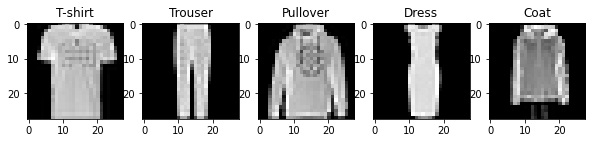

In [3]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(y == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(X[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels[i]))

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.
    
</div>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

Para poder visualizar los resultados de cada algoritmo supervisado, reduciremos el dataset anterior a dos dimensiones.

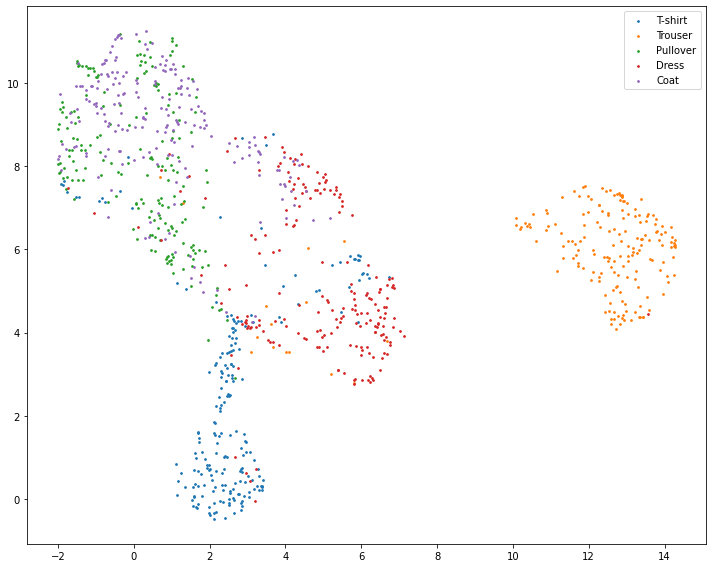

In [5]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(n_classes):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=3, label=labels[i])
plt.legend()
plt.tight_layout()

A lo largo de los ejercicios aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde.

In [147]:
# vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1

# definimos la función que visualizará la frontera de decisión
def plot_decision_boundaries(model, X_test_projection, y_test):

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    # precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # definimos los colores (uno para cada clase)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink'])
    cmap_bold = ['grey','g','sandybrown','c','palevioletred']

    # dibujamos las fronteras
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.2)

    # dibujamos los puntos
    for i in range(n_classes):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], 
                    s=3, label=labels[i], c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())  

### 1.1. Gaussian Naïve Bayes

El objetivo de este primer ejercicio es entender el funcionamiento del algoritmo Naïve-Bayes, un algoritmo peculiar ya que se basa completamente en teoría de probabilidades.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el dataset de _train_, entrenad un modelo Naïve-Bayes y representad gráficamente la frontera de decisión con el de _test_. Podéis utilizar el clasificador **GaussianNB** de `sklearn`.
    
Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_ y la matriz de confusión sobre _test_. Podéis utilizar `accuracy_score` y `confusion_matrix` del paquet `metrics` de `sklearn`.
</div>

In [125]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

In [126]:
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.69

In [127]:
confusion_matrix(y_test, y_pred)

array([[128,   1,  13,  67,   3],
       [  0, 147,   2,  37,   0],
       [  2,   0,  71,  26,  95],
       [  5,   0,   4, 190,   6],
       [  1,   0,  13,  35, 154]], dtype=int64)

In [136]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

clf = GaussianNB()
clf.fit(X_train_projection, y_train)

GaussianNB()

In [138]:
print(X_train_projection.shape, X_test_projection.shape, y_train.shape, y_test.shape)

(4000, 2) (1000, 2) (4000,) (1000,)


C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


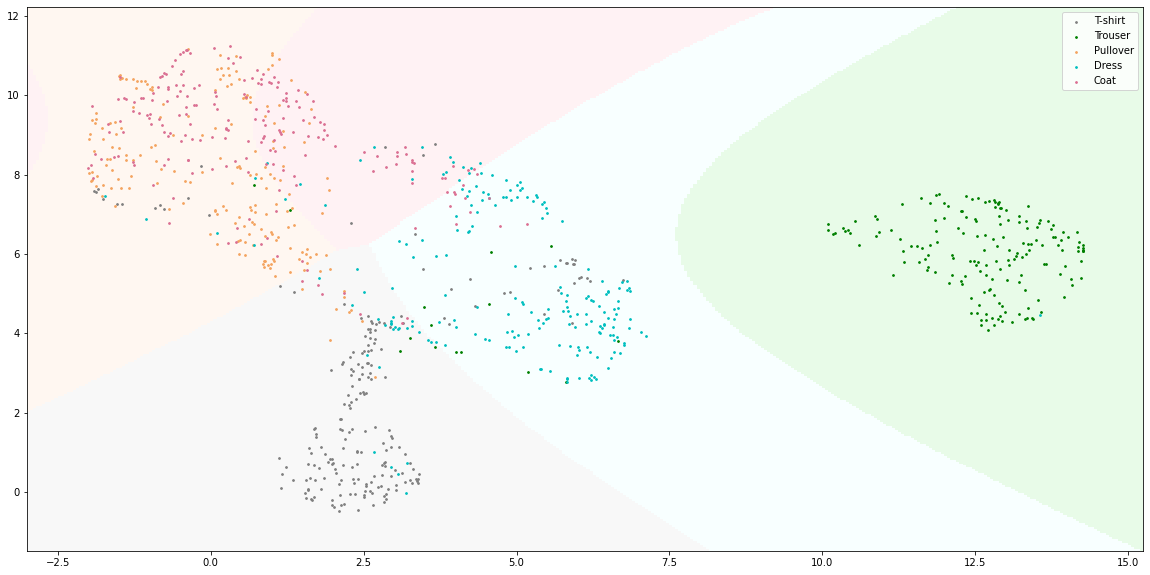

In [148]:
plot_decision_boundaries(clf, X_test_projection, y_test)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
  
Análisis del ejercicio.

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

Las fronteras del árbol están bien definidas y siguen formas de tiras. Las predicciones son aceptables, con este modelo se reconocen el 69% de las instancias. Pero es sensible a zonas en las que hay overlap entre dos clases como sucede entre "pullover" y "coat". De manera que no es capaz de diferenciar bien estas dos clases.

Por otro lado, que las zonas estén tan claramente diferenciadas evitará el overfitting. Este modelo es mucho más probable que en nuevos datos mantenga un renidimiento similar. Por ejemplo, la mayoría de las instancias de la clase "trousers" se encuentran en una nube de puntos diferenciada del resto de instancias. Aún así, algunas instancias de este grupo están en la nube de puntos y se están clasificando erróneamente en otras categorías. Algoritmos más sensibles las podrían clasificar correctamente, pero también podrían tratarse de outliers y acabar entrenando un modelo con una capacidad muy alta de predicción en los datos del test, pero con un mal rendimiento en entornos reales de producción.

La forma de las fronteras tiene sentido con el funcioamiento de este algoritmo. Naive Bayes funciona asignando a cada instancia la clase más probable. Por ejemplo, si en una base de datos tenemos que las personas jovenes que viven en ciudades tienen una mayor probabilidad de usar el transporte público. Cuando el modelo encuentre una persona joven que vive en una ciudad le asignará la clase de usar transporte público. 

Por último, este modelo tiene un rendimiento correcto y no ha sido necesario establecer ningún parámetro. Por lo tanto, este modelo puede ser más accesible para personas sin muchos conocimientos de ML.

### 1.2. KNN

El objetivo de este segundo ejercicio es entender el funcionamiento del KNN, intuir sus principales ventajas o desventajas y entender la influencia de los parámetros de los que está compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qué significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicción.

¿Cómo funciona KNN?

  - Calculamos la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos más cercanos, es decir, con menor distancia, según la distancia que utilizamos (euclídea, coseno, manhattan, etc).
  - Por último realizamos una "votación de mayoría" entre los k puntos: los de la clase que "dominan" decidirán su clasificación final.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con el dataset de _train_, entrenad un modelo KNN con `n_neighbors = 2` y representad gráficamente la frontera de decisión con el de _test_.
    
Podéis utilizar el clasificador **KNeighborsClassifier** de `sklearn`.
</div>

In [13]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [14]:
y_pred = neigh.predict(X_test)

accuracy_score(y_test, y_pred)

0.845

In [15]:
confusion_matrix(y_test, y_pred)

array([[192,   0,   9,   9,   2],
       [  3, 173,   0,   8,   2],
       [  8,   0, 158,   0,  28],
       [ 16,   2,   8, 168,  11],
       [  4,   0,  40,   5, 154]], dtype=int64)

C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


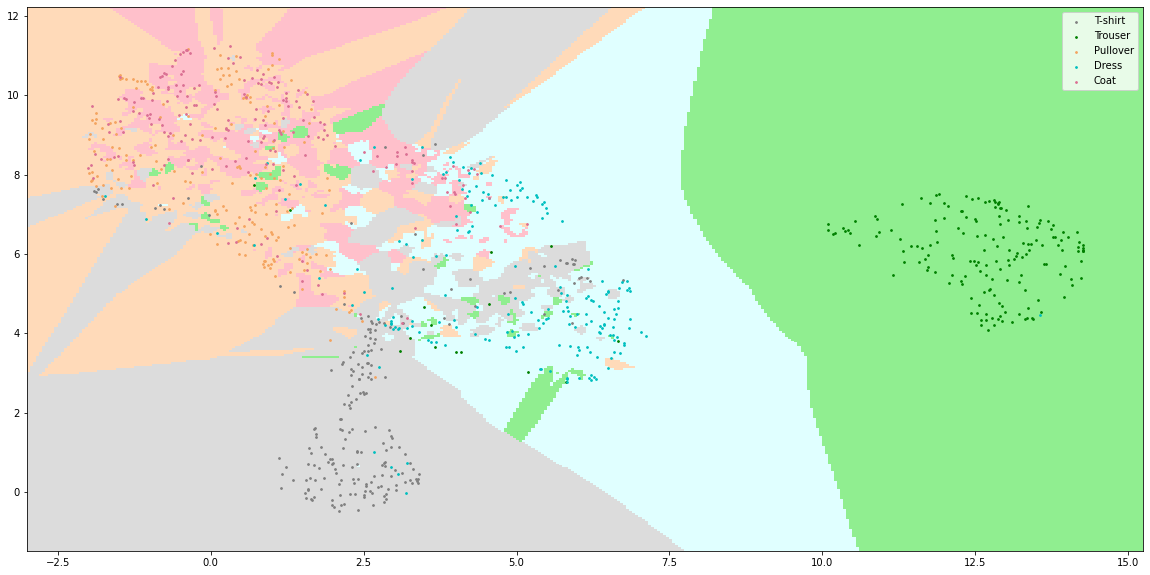

In [140]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train_projection, y_train)

plot_decision_boundaries(neigh, X_test_projection, y_test)

En el modelo entrenado, hemos fijado el parámetro `n_neighbors` de forma arbitraria. Pero podría ser que con otro valor obtuviéramos una mejor predicción.

Para conocer el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_) se suele utilizar una búsqueda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinación de hiperparámetros posible y evaluarlo utilizando validación cruzada (_cross validation_) con 4 particiones estratificadas. Posteriormente, se elige la combinación de hiperparàmetres que mejores resultados haya obtenido.

En este caso sólo queremos optimizar un hiperparámetro:

   - 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Cálculo del valor óptimo del hiperparámetro _k_ (`n_neighbors`). Utilizad una búsqueda de rejilla con validación cruzada para encontrar el valor óptimo de _k_. Por cada valor, calculad su promedio y la desviación estándar. Implementad un _heatmap_ para visualizar la precisión según los diferentes valores del hiperparámetro.
    
Puede utilizar el módulo `GridSearchCV` de `sklearn` el cálculo del mejor hiperparámetro, y `heatmap` de `Seaborn`.
</div>

In [143]:
# parametros que vamos a probar para estimar el mejor modelo.
k_vals = list(np.linspace(1, 10, 10).astype(int))

parameters = {'n_neighbors':k_vals}

neigh = KNeighborsClassifier()
grid = GridSearchCV(neigh, parameters, cv=4)

grid.fit(X_train, y_train)

grid.best_params_

{'n_neighbors': 7}

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con el mejor hiperparámetro encontrado, volved a entrenar un clasificador KNN (con _train_) y representar las fronteras de decisión con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Podéis utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

In [144]:
neigh = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)

accuracy_score(y_test, y_pred)

0.86

In [145]:
confusion_matrix(y_test, y_pred)

array([[195,   0,   9,   6,   2],
       [  2, 174,   0,   9,   1],
       [  6,   0, 162,   0,  26],
       [ 15,   1,  12, 168,   9],
       [  4,   0,  34,   4, 161]], dtype=int64)

C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


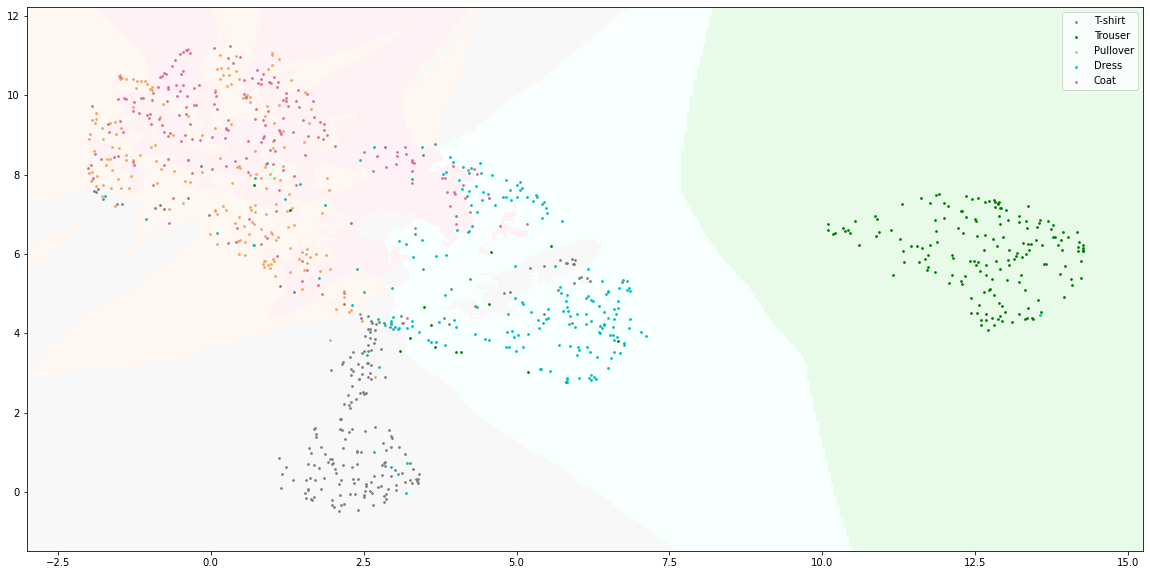

In [149]:
neigh = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
neigh.fit(X_train_projection, y_train)

plot_decision_boundaries(neigh, X_test_projection, y_test)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Análisis del ejercicio:

   - Comentar los resultados de la búsqueda del mejor hiperparámetro.
   - ¿Cómo se visualiza gráficamente el cambio del valor `n_neighbors`? ¿Tiene sentido esta diferencia entre los dos gráficos al cambiar el parámetro?
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

De nuevo tenemos un algoritmo que es muy sencillo de entender conceptualmente. Para cada nueva instancia, se buscan las k instancias más cercanas y se clasifica esta como la clase más frecuente. Si tenemos un valor de k=5, se buscarán las 5 instancias más cercanas. Pongamos que 3 pertenecen a la clase A y 2 a la clase B. En ese caso, se asignará la nueva instancia como clase A.

En el caso anterior, hemos visto que este modelo tiene una capacidad predictiva mayor. En este caso, la capacidad predictiva es de un 86% en el último modelo. 

La diferencia en el rendimiento de utilizar 2 vecinos a usar 7 es pequeña. Aún así, en el último caso las fronteras de decisión son más grandes. En el primer intento, con 2 vecinos, las fronteras podían llegar a ser muy pequeñas y esto puede llevar a más errores en el conjunto de test. El algoritmo podría acaba describiendo los datos de entrenamiento y no ser capaz de tener un buen rendimiento en el conjunto de test. Por otro lado, es lógico que las fronteras sean más pequeñas con valores de k pequeños porque tomamos una decisión sobre una muestra más pequeña. A más grande k, la muestra con la que se decidirá la clase de la instancia será mayor y se reducirá el ruido local, pero a riesgo de considerar datos muy alejados que puedan pertenecer a otras categorías y generar un modelo con underfitting.

La capacidad de prediccón es mayor que en el algoritmo anterior. Esto es así porque el algoritmo es capaz de diferenciar entre las dos clases en las que había overlap. Este algoritmo es más sensible y es capaz de detectar más detalles que el algoritmo anterior pasaba desapercibidos. Las fronteras de decisión están creadas de manera que la parte "sur" de estos dos grupos, en los que había overlap, se están clasificando como "Pullover". Mientras que las instancias que tienen valores más altos en el eje de la Y se clasifican como "Coat". En el modelo anterior se estaban clasificando la mayoría de estas instancias como "Pullover".

### 1.3. SVM

Las Support Vector Machine (SVM) se fundamentan en el _Maximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones p-1. El término afín significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como _maximal margin hyperplane_ o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cómo de lejos está el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización.

El proceso de optimización tiene la peculiaridad de que sólo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del núcleo .

El truco del núcleo (_kernel trick_) consiste en utilizar una dimensión nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM también dependen de varios hiperparámetros. 

En este caso intentaremos optimizar dos hiperparámetros:

  - **C**: es la regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - **Gama**: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto más pequeño es gama, más influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (_cross-validation_) con 4 particiones estratificadas.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Cálcular del valor óptimo de los hiperparámetros _C_ y _gama_. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Podéis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador SVC (de `SVM` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

In [49]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

param_grid = {'C':[0.01, 0.1, 1, 10, 50, 100, 200],
              'gamma':[0.001, 0.01, 0.1, 1, 10]}
svm = SVC()
grid = GridSearchCV(svm,param_grid, cv=4)

grid.fit(X_train, y_train)

grid.best_params_

{'C': 10, 'gamma': 0.01}

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encuentrada, entrenad un clasificador `SVM` (con _train_) y representar las fronteras de decisión con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

In [50]:
clf = SVC(C=10, gamma = 0.01, random_state=42)
scores = cross_val_score(clf, X_train,y_train, cv=5)
scores

array([0.90875, 0.88   , 0.8925 , 0.885  , 0.8775 ])

In [51]:
print("%0.2f accuracy con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

0.89 accuracy con una desviación estándar de 0.01


In [52]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict() en vez de retornar los scores, devuelve las predicciones de cada test fold
y_train_pred = cross_val_predict(clf, X_train,y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

array([[731,   0,  15,  36,   6],
       [  5, 785,   4,  18,   2],
       [ 21,   2, 674,  15,  94],
       [ 43,   6,  13, 706,  27],
       [  1,   1, 100,  36, 659]], dtype=int64)

C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


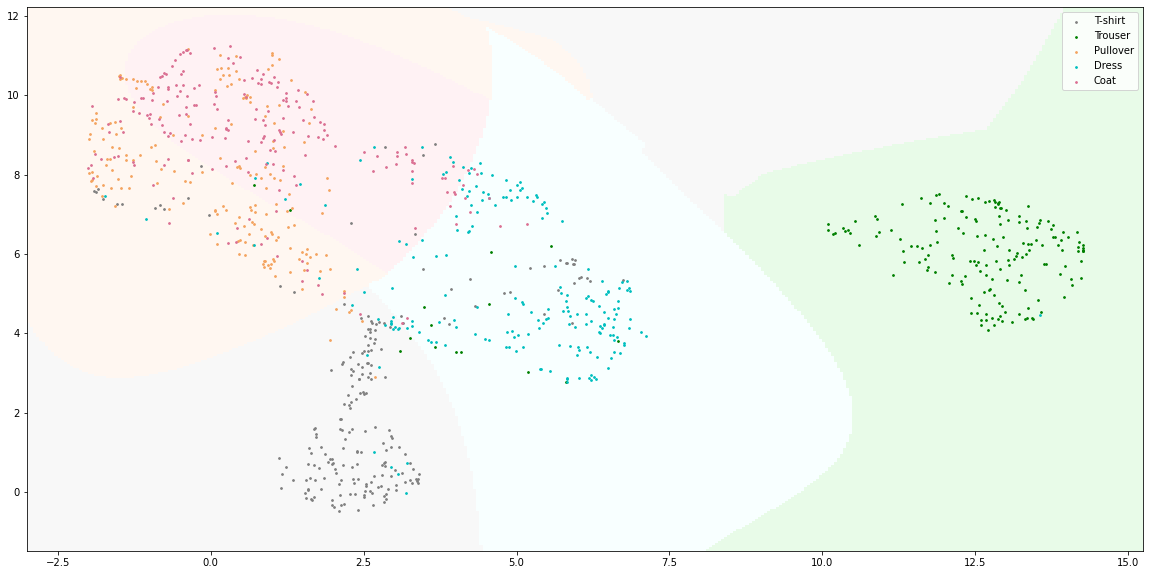

In [150]:
clf = SVC(C=10, gamma = 0.01, random_state=42)
clf.fit(X_train_projection, y_train)

plot_decision_boundaries(clf, X_test_projection, y_test)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

Usando la validación cruzada, he encontrado que los mejores hiperparámetros para este conjunto de datos son 'C'=10 y 'gamma'=0.01. De manera que en el algoritmo tienen más incidencia los puntos cercanos y el margen entre las categorías no es especialmente grande. 

Este algoritmo trata de crear un plano o un hiperplano (en función de las dimensiones) que genere el mayor margen posible entre dos clases. Buscando un margen que genere la mayor distancia entre puntos (support vectors) que pertenecen a dos clases diferentes. Como el valor de gamma es pequeño, la frontera entre las categorías tiene una forma más cilindríca y no tan 

Las predicciones del test tienen una precisión del 89% con una desviación del 0.01%. Lo que significa que el modelo se está mostrando fiable. Lo que significa que no deberíamos observar una bajada de rendimiento significativa una vez el algoritmo esté en producción (excepto si los datos de entrenamiento están sesgados y no representan bien los datos reales).

Una predicción del 89% será buena o mala en función de los objetivos de negocio. En algunas industrias o para algunos problemas puede ser suficiente, pero en algunas otras no. Aún así, el incremento en rendimiento del algoritmo de SVM es mayor que el de los algoritmos entrenados anteriormente.

### 1.4. Árboles de decisión

Los árboles de decisión son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Los árboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcción de un árbol

La creación de las ramificaciones de los árboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del árbol, donde todas las observaciones pertenecen a la misma región.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se evalúan las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entropía, chi-square.

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperparámetros:

   - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el número mínimo de observaciones que debe tener una hoja del árbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Calculad el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Pódeis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

In [60]:
param_grid = {'max_depth':list(np.linspace(4, 10, 7).astype(int)),
              'min_samples_split':[2, 10, 20, 50, 100]}

dtc = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(dtc,param_grid, cv=4)

grid.fit(X_train, y_train)

grid.best_params_

{'max_depth': 8, 'min_samples_split': 2}

In [92]:
df = pd.DataFrame.from_dict(grid.cv_results_).iloc[:,6:-2].set_index('params')
df.head()

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score
params,,,,,
"{'max_depth': 4, 'min_samples_split': 2}",0.754,0.780,0.751,0.772,0.76425
"{'max_depth': 4, 'min_samples_split': 10}",0.754,0.777,0.750,0.771,0.76300
"{'max_depth': 4, 'min_samples_split': 20}",0.753,0.776,0.750,0.773,0.76300
"{'max_depth': 4, 'min_samples_split': 50}",0.753,0.776,0.750,0.772,0.76275
"{'max_depth': 4, 'min_samples_split': 100}",0.753,0.776,0.750,0.772,0.76275


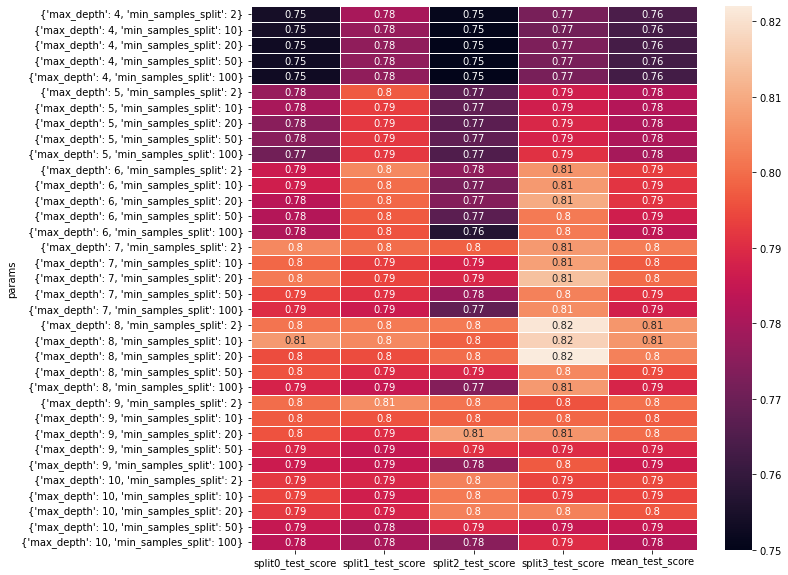

In [96]:
plt.figure(figsize=(10,10))

sns.heatmap(df, annot=True, linewidth=.5)

plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrados, entrenad un clasificador `DecisionTreeClassifier` (con `train`) y representar las fronteras de decisión con los puntos de `test`.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

In [99]:
dtc = DecisionTreeClassifier(max_depth=8, min_samples_split=2)

scores = cross_val_score(dtc, X_train,y_train, cv=5)
scores

array([0.80625, 0.79875, 0.805  , 0.7825 , 0.79   ])

In [100]:
print("%0.2f accuracy con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

0.80 accuracy con una desviación estándar de 0.01


In [101]:
y_train_pred = cross_val_predict(dtc, X_train,y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

array([[662,   7,  25,  77,  17],
       [  7, 753,   3,  47,   4],
       [ 20,   5, 594,  27, 160],
       [ 68,  32,  22, 644,  29],
       [ 12,   9, 163,  61, 552]], dtype=int64)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


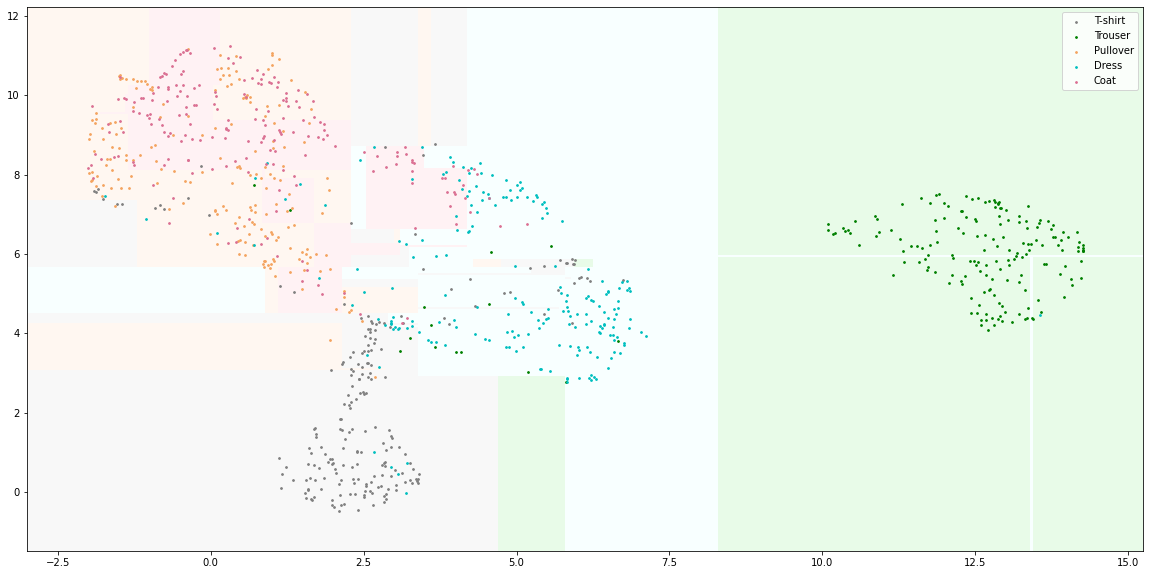

In [151]:
dtc = DecisionTreeClassifier(max_depth=8, min_samples_split=2)
dtc.fit(X_train_projection, y_train)

plot_decision_boundaries(dtc, X_test_projection, y_test)

Los árboles de decisión funcionan mediante reglas lógicas. De manera que se van clasificando las instancias en función de si cumplen una determinada condición. En este caso, se clasifican como T-shirts aquellas instancias que tienen un valor superior a 7.5. Y se van agrupando los datos de esta manera. Buscando crear pequeños grupos lo que da la imagen de mosaico que vemos en la imagen.

Las predicciones no son especialmente buenas si las comparamos con las de SVM o las de KNN. Aunque el rendimiento de este árbo de decisión no es muy bueno, versiones mejoradas de estos como los Random Forest tienen un rendimiento mucho mayor. De hecho, el algoritmo XGBoost es uno de los algoritmos que se suelen utilizar para ganar competiciones de Machine Learning (Gerón, 2019).

### 1.5. Mejorando los árboles de decisión

En la práctica, casi nunca se utiliza un solo árbol de decisión, sino que se combinan muchos árboles para obtener mejores resultados. Hay dos maneras de combinar árboles:

  - *__Bagging__*: utilizar el conjunto de entrenamiento original para generar centenar o miles de conjuntos similares utilizando muestreo con reemplazo. El algoritmo _random forest_ está basado en este concepto, la combinación de varios árboles de decisión, cada uno entrenado con una muestra diferente de los datos. La decisión final del clasificador combinado (la _random forest_) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).
  
  - *__Boosting__*: se combinan varios clasificadores débiles secuencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificadas en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.
  
Ambos métodos los estudiaremos más en detalle en la próxima PEC, pero en esta haremos un vistazo a los beneficios que nos aporta utilizar combinaciones de árboles respecto un solo árbol.

Al tratarse de árboles, sigue siendo importante optimizar `max_depth` y `min_samples_split`, pero en este caso añadiremos un hiperparámetro más. Para simplificar, de los dos parámetros anteriores optimizaremos sólo `max_depth`:

  - `n_estimators`: número de árboles. Exploraremos los valores: 50, 100 y 200.
  - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 8 y 12.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Escoged uno de los dos algoritmos mencionados: RandomForestClassifier o GradientBoostingClassifier. Calculad el valor óptimo de los hiperparámetros `n_estimators` y `max_depth`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Podéis utilizar el módulo `GridSearchCV` de `sklearn` para el cálculo de los mejores hiperparámetros con el clasificador `RandomForestClassifier` o `GradientBoostingClassifier` (de `ensemble` de `sklearn`), y `heatmap` de `Seaborn`.
    
<u>Nota</u>: al utilizar tantos árboles, el _cross validation_ con todas las combinaciones de parámetros es más costosa que en los ejemplos anteriores, y por lo tanto tardará más en ejecutarse.
</div>

In [152]:
param_grid = {'n_estimators':[50, 100, 150, 200],
              'max_depth':[8, 12]}

gbc = GradientBoostingClassifier(random_state=42)

grid = GridSearchCV(gbc,param_grid, cv=4)
grid.fit(X_train, y_train)
grid.best_params_

{'max_depth': 8, 'n_estimators': 200}

In [155]:
gbc = GradientBoostingClassifier(n_estimators=grid.best_params_['n_estimators'], max_depth=grid.best_params_['max_depth'])
gbc.fit(X_train_projection, y_train)

GradientBoostingClassifier(max_depth=8, n_estimators=200)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrada, entrenad un clasificador con el modelo elegido (con _train_) y representar las fronteras de decisión con los puntos de test.
    
Calcular el _accuracy_ del modelo obtenido sobre test y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

In [156]:
scores = cross_val_score(gbc, X_train, y_train, cv=5)

print("Precisión:", scores)

print("%0.2f accuracy con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

Precisión: [0.885  0.88   0.8825 0.8775 0.885 ]
0.88 accuracy con una desviación estándar de 0.00


In [157]:
y_train_pred = cross_val_predict(gbc, X_train,y_train, cv=3)

confusion_matrix(y_train, y_train_pred)

array([[716,   0,  26,  40,   6],
       [  5, 780,   3,  24,   2],
       [ 21,   0, 661,  13, 111],
       [ 32,   6,  12, 722,  23],
       [  2,   5,  97,  44, 649]], dtype=int64)

C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


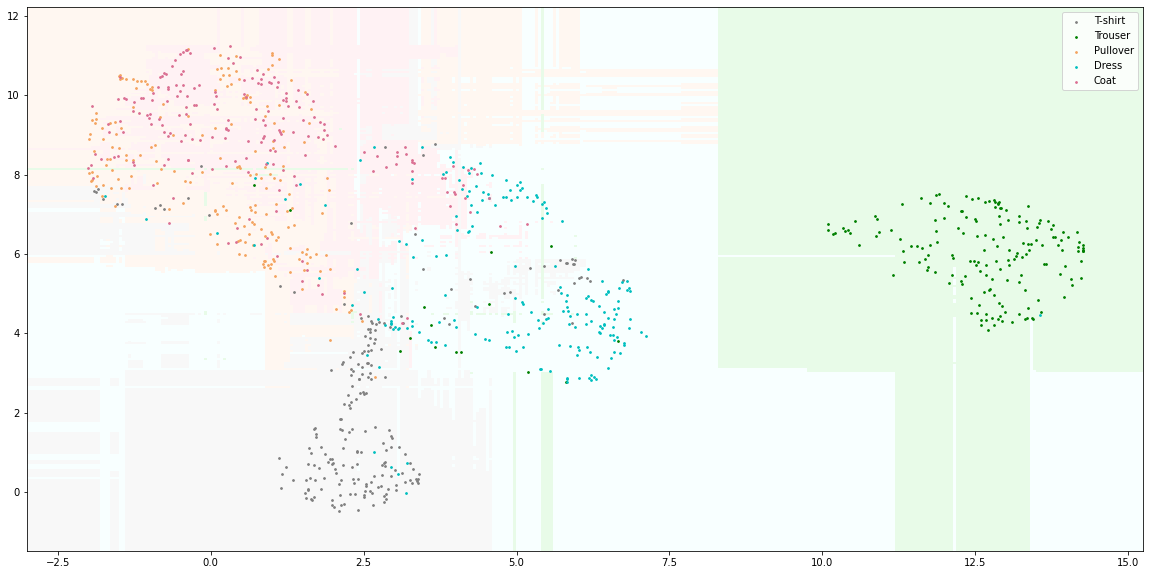

In [154]:
plot_decision_boundaries(gbc, X_test_projection, y_test)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
   - ¿Ha habido mejora respecto a utilizar un simple árbol de decisión?
</div>

Como en el caso del árbol de decisión, se generan mosacios. En este caso, los mosaicos son más pequeños y se aprecia que el modelo es más sensible y más preciso con los datos. Esto es así porque este algoritmo funciona entrenando múltiples árboles de decision en una pequeña muestra de los datos. Las predicciones se hacen con todos los árboles y la clase resultante es la que ha obtenido más votos entre todos estos árboles. De manera que tiene un rendimiento mayor que un árbol de decisión y que por lo tanto, que las fronteras de decisión no sean tan lineales y más detalladas, porque el modelo resultante es más sensible. 

La precisión mejora respecto al anterior método. La precisión es del 88%. Al final, estamos entrenando muchos árboles de decisión con ligeras diferencias y quedandonos con el mejor resultado que producen. De manera que los errores locales que pueda hacer un árbol quedan mitigados por la media de todos los árboles.

<a id='ej2'></a>
# 2. Implementación del caso práctico (5 puntos)

En este caso práctico, construiremos un modelo predictivo que detectará si el comentario escrito por un usuario de Amazon en una reseña sobre una aplicación para Android es bueno o no, utilizando exclusivamente el texto de dicho comentario como punto de partida. El problema que vamos a resolver en este apartado se engloba dentro del área de investigación conocida como [análisis de sentimiento (_sentiment analysis_)](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_sentimiento) que utiliza, entre otras cosas, procesamiento de lenguaje natural, análisis de texto y lingüística computacional para identificar y extraer información subjetiva de distintos recursos.

El conjunto de datos con el que trabajaremos se ha obtenido de las valoraciones y comentarios dejados por un grupo de usuarios en las reseñas de diferentes productos de Amazon. En nuestro caso, nos centraremos en un subconjunto de 10000 reseñas de aplicaciones para Android con valoraciones desde 1 hasta 5 estrellas. El conjunto de datos original lo podéis encontrar en el siguiente enlace: http://jmcauley.ucsd.edu/data/amazon/

## 2.0. Carga de datos

Lo primero que haremos será cargar el dato, que viene dentro de un fichero donde cada línea es una reseña en formato [JSON](https://es.wikipedia.org/wiki/JSON).

In [2]:
N_SAMPLES = 10000

review_list = []
with open("Apps_for_Android_5.json", "rt") as f:
    for i, line in enumerate(f):
        if i >= N_SAMPLES:
            break
        review_list.append(json.loads(line))

len(review_list)

10000

Como podemos ver en la siguiente celda, cada reseña se compone de, entre otras cosas, comentario (`'reviewText'`) y valoración (`'overall'`).

In [3]:
review_list[0]

{'reviewerID': 'A1N4O8VOJZTDVB',
 'asin': 'B004A9SDD8',
 'reviewerName': 'Annette Yancey',
 'helpful': [1, 1],
 'reviewText': "Loves the song, so he really couldn't wait to play this. A little less interesting for him so he doesn't play long, but he is almost 3 and likes to play the older games, but really cute for a younger child.",
 'overall': 3.0,
 'summary': 'Really cute',
 'unixReviewTime': 1383350400,
 'reviewTime': '11 2, 2013'}

## 2.1. Preprocesamiento de los datos

Con el objetivo de aplicar algunos de los algoritmos vistos en el primer apartado de la PEC, procesaremos el conjunto de datos inicial para poder obtener desde el texto del comentario una serie de atributos descriptivos numéricos lo suficientemente representativos como para que al construir sobre ellos un clasificador obtengamos los resultados esperados.

El procesamiento del texto realizará los siguientes pasos:
- El texto se pasará por completo a letras minúsculas, minimizando la variedad de palabras resultante.
- Los números, direcciones de páginas web y de correo y el símbolo del dólar se substituirán por palabras especiales.
- Separación del texto en las palabras que posteriormente darán lugar a los futuros tokens.
- Eliminación de los caracteres no alfanuméricos que puedan quedar.
- Eliminación de [palabras vacías (_stopwords_)](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa) que no aportan información, tales como artículos o preoposiciones.
- Simplificación de las palabras quedándonos sólo con el lexema (raíz) de la misma, unificando en un solo token distintas palabras relacionadas semánticamente.

La siguiente funcion toma una reseña y devuelve una dupla formada por los tokens resultantes del procesado y si la valoración es buena o no, es decir, si su valoración es mayor que 3 o no.

In [4]:
def process_review(review):
    text = review['reviewText']
    # Pasamos el texto a minúsculas para minimizar la variedad de palabras.
    text = text.lower()
    # Reemplazamos los números por el token 'number'.
    text = re.sub('[0-9]+', 'number', text)
    # Cualquier cosa que comience con http o https:// es reemplazado por 'httpaddr'.
    text = re.sub('(http|https)://[^\s]*', 'httpaddr', text)
    # Cadenas de texto con "@" en su interior son consideradas direcciones de email: 'emailaddr'.
    text = re.sub('[^\s]+@[^\s]+', 'emailaddr', text)
    # El signo '$' es reemplazado por el token 'dollar'.
    text = re.sub('[$]+', 'dollar', text)
    # Separamos el comentario en palabras individuales o tokens.
    words = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]', text)
    
    # Usaremos PorterStemmer para extraer las raíces de las palabras.
    stemmer = nltk.stem.porter.PorterStemmer()
    # Carreguem les "stopwords" angleses en un set perquè aquest és més eficient que una llista.
    stopwords = set(stopword.lower() for stopword in nltk.corpus.stopwords.words('english'))
    # 
    tokens = []
    for word in words:
        # Eliminamos todo aquello que no sean caracteres alfanuméricos.
        token = re.sub('[^a-zA-Z0-9]', '', word)
        # Tomamos únicamente sólo quellos los tokens que no estén vacíos ni pertenezcan al conjunto "stopwords"
        if token and word not in stopwords:
            # Extraemos la raíz de cada palabra.
            token = stemmer.stem(token)
            # Añadimos el token a la lista.
            tokens.append(token)
        
    # Devolvemos el token y si la reseña es buena o no (buena si la puntuación es mayor que 3).
    return tokens, review['overall'] > 3

In [5]:
process_review(review_list[0])

(['love',
  'song',
  'realli',
  'wait',
  'play',
  'littl',
  'less',
  'interest',
  'play',
  'long',
  'almost',
  'number',
  'like',
  'play',
  'older',
  'game',
  'realli',
  'cute',
  'younger',
  'child'],
 False)

Con ayuda de la función definida previamente, procesamos todas las reseñas:

In [6]:
tokens_list = []
y_list = []
for review in review_list:
    tokens, is_good = process_review(review)
    tokens_list.append(tokens)
    y_list.append(1 if is_good else 0)

In [7]:
tokens_list[0], y_list[0]

(['love',
  'song',
  'realli',
  'wait',
  'play',
  'littl',
  'less',
  'interest',
  'play',
  'long',
  'almost',
  'number',
  'like',
  'play',
  'older',
  'game',
  'realli',
  'cute',
  'younger',
  'child'],
 0)

In [8]:
y = np.array(y_list)

En este punto, para cada reseña tenemos un valor binario que nos indica si es buena o no (variable objetivo) y una lista de tokens que puede o no tener elementos en común con las las listas de tokens de otras reseñas. Estas listas de tokens, tal y como están, aún no nos sirven a modo de atributos descriptivos para poder entrenar un modelo como los que hemos visto previamente.

Con el propósito de crear un número de variables igual y con el mismo significado para todas y cada una de las muestras, nos decidimos a elegir los tokens comunes en al menos el 1% de los comentarios para, posteriormente, realizar un conteo de veces que aparece cada uno de dichos tokens en cada reseña y generar, para cada reseña, un vector de variables numéricas en la que cada posición hace referencia a cada uno de esos tokens relevantes o comunes e indica cuántas veces aparece diccho token en el comentario en cuestión. A esta técnica se la conoce como bolsa de palabras (_bag of words_).

Sin embargo, antes de realizar este proceso, debemos dividir el conjunto de datos en los subconjuntos de entrenamiento y de test, ya que las palabras comunes las debemos decidir teniendo en cuenta sólo los datos de entrenamiento, puesto que cuando tengamos nuestro algoritmo en producción nos encontraremos con reseñas que no habremos tenido en cuenta para generar la mencionada lista de tokens comunes y debemos de estar preparados para ello simulándolo con el subconjunto de test.

Como última aclaración, es imporante, antes de dividir el dataset, conocer cómo es la distribución de las clases dentro del mismo, ya que si esta distribución no está equilibrada es necesario estratificar la división.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Estudia la distribución de valoraciones y de la clase (variable objetivo) "_es buena o no_".
    
</div>

In [9]:
y

array([0, 1, 1, ..., 1, 1, 1])

<AxesSubplot:ylabel='Count'>

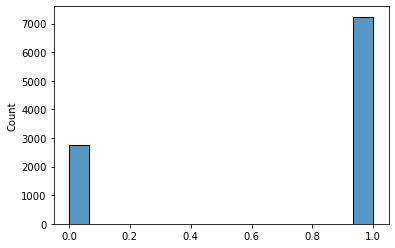

In [10]:
sns.histplot(y)

Como se puede observar en este histograma, la distribución de la variable objetivo no está equilibrada. Ya que hay muchas más reseñas valoradas como buenas (con valor igual a 0) que malas. Por esta razón, usaremos la estratificación para preservar que haya suficientes casos de la categoría poco frecuente tanto en el conjunto de train como test.

REFERENCIAS:

https://scikit-learn.org/stable/modules/cross_validation.html#stratification

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: tokens_list_train, tokens_list_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.

<u>Nota:</u> utilizad el parámetro `stratify` en caso de que sea necesario.
    
</div>

In [12]:
tokens_list_train, tokens_list_test, y_train, y_test = train_test_split(tokens_list, y,
                                                                        test_size=0.2,
                                                                        random_state=24,
                                                                        stratify=y)

Es el momento de elegir una lista de los tokens representativos del conjunto de muestras de entrenamiento. Llamaremos a esta lista vocabulary.

Para hacer esto, voy a seleccionar de todas las reseñas, los valores únicos de todas ellas. Es decir, voy a seleccionar todos los términos que aparecen como mínimo una única vez en la lista de tokens de entrenamiento y eliminar los valores duplicados.

In [69]:
voc = []
for l in tokens_list_train:
    for t in l:
        voc.append(t)

vocabulary = list(set(voc))

In [55]:
print('Elementos en voc:', len(voc))
print('Términos únicos:', len(vocabulary))

Elementos en voc: 189717
Términos únicos: 8835


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Guarda en la variable __*vocabulary*__ la lista de tokens que aparecen al menos en un 1% de las reseñas de entrenamiento.
    
</div>

Como vamos a quedarnos sólo con los tokens que estén presentes en el 1% de las reseñas, tendremos que hacer este caluclo eliminando los tokens que estén repetidos en una misma reseña. Por ejemplo, tenemos 1000 reseñas. En una de ellas aparece 10 veces un término o token. si no eliminamos las veces que ese token está repetido en esa reseña, podemos incluirla en la lista final de tokens aunque estaba únicamente en una reseña, pero repetida muchas veces.

In [18]:
len(list(set(tokens_list_train[9])))

35

In [19]:
len((tokens_list_train[9]))

36

In [30]:
token_list_train_unique = [list(set(i)) for i in tokens_list_train]
token_list_train_unique[1]

['hangman',
 'game',
 'get',
 'great',
 'tire',
 'think',
 'mind',
 'play',
 'keep',
 'frustrat']

A partir de esta última lista, tengo que encontrar los tokens que aparecen en más del uno por ciento de reseñas.

In [65]:
# lista de tokens con repeticiones en otras reseñas
words = []
for l in token_list_train_unique:
    for t in l:
        words.append(t)

In [102]:
vocabulary[0:10]

['fishermen',
 'easier',
 'celeb',
 'handi',
 'strike',
 'disappointingli',
 'quit',
 'blocker',
 'sd',
 'somethingthat']

Para elaborar la lista con los tokens que aparecen en el 1% de las reseñas, voy a elaborar una función que a partir de una lista de reseñas, devuelva aquellas que estén presentes en más de un porcentaje determinado. 

In [99]:
def token_list(array=tokens_list_train, perc=1):
    #lista sin valores repetidos en las reseñas
    token_list_train_unique = [list(set(i)) for i in array]
    token_list_train_unique[1]

    # lista de tokens con repeticiones en otras reseñas
    words = []
    for l in token_list_train_unique:
        for t in l:
            words.append(t)

    # elaboro una lista con los tokens que superan el threshold
    vocabulary_short = []
    threshold = (perc/100)*len(tokens_list_train)
    for word in vocabulary:
        if words.count(word) > threshold:
            vocabulary_short.append(word)
    return vocabulary_short

In [101]:
vocabulary_short = token_list()

In [103]:
len(vocabulary_short)

399

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Crea en la variable <i><strong>vocabulary_dictionary</strong></i> el diccionario formado por los tokens (claves) y su posición dentro de la lista __*vocabulary*__.
    
</div>

Con la lista de tokens obtenida crearemos un diccionario para poder traducir cada uno de ellos a un identificador numérico: la posición que ocupará la palabra dentro del vector resultante.

A cada token le asignamos un número que funcionará como identificador. Para crear el diccionario utilizaré la función dictionary comprenhension de Python. Para comprobar que el código es el adecuado, haré una pequeña prueba con una versión reducida de los tokens:

In [107]:
{vocabulary_short[i]: i for i in range(0, len(vocabulary_short[:8]))}

{'easier': 0,
 'handi': 1,
 'quit': 2,
 'version': 3,
 'site': 4,
 'color': 5,
 'chang': 6,
 'annoy': 7}

In [143]:
vocabulary_dictionary = {vocabulary_short[i]: i for i in range(0, len(vocabulary_short))}

In [145]:
vocabulary_dictionary2 = {key: value+1 for (key,value) in vocabulary_dictionary.items()}

Finalmente, con la ayuda del diccionario que acabamos de crear, transformaremos todos los comentarios de las reseñas, tanto de entrenamiento como de test, en vectores numéricos del mismo tamaño donde cada posición hará referencia a cada uno de los tokens de la lista __*vocabulary*__ guardando el número de veces que aparece dicho token en la muestra.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Crea las variables <i><strong>X_train</strong></i> y <i><strong>X_test</strong></i> transformando las variables <i><strong>tokens_list_train</strong></i> y <i><strong>tokens_list_test</strong></i> con ayuda del diccionario <i><strong>vocabulary_dictionary</strong></i>.

<u>Nota:</u> la clase `Counter` del módulo `collections` te será muy útil para este cometido.

</div>

In [152]:
c = Counter(vocabulary_dictionary2)
c

Counter({'easier': 1,
         'handi': 2,
         'quit': 3,
         'version': 4,
         'site': 5,
         'color': 6,
         'chang': 7,
         'annoy': 8,
         'old': 9,
         'space': 10,
         'away': 11,
         'interfac': 12,
         'came': 13,
         'choic': 14,
         'listen': 15,
         'clear': 16,
         'miss': 17,
         'cloud': 18,
         'name': 19,
         'challeng': 20,
         'interest': 21,
         'howev': 22,
         'game': 23,
         'abl': 24,
         'peopl': 25,
         'one': 26,
         'especi': 27,
         'instead': 28,
         'user': 29,
         'much': 30,
         'littl': 31,
         'pc': 32,
         'home': 33,
         'pick': 34,
         'minut': 35,
         'full': 36,
         'still': 37,
         'pleas': 38,
         'quickli': 39,
         'definit': 40,
         'android': 41,
         'list': 42,
         'channel': 43,
         'far': 44,
         'scanner': 45,
         'cute': 

La columna cero representará los tokens que no tienen un id asignado. Bien porque no estaban presentes en la variable de train o porque no eran lo suficientemente frecuentes. 

In [149]:
tokens_list_train[2]

['go',
 'cementari',
 'ghostseveryon',
 'know',
 'ghost',
 'realli',
 'cementaryfakest',
 'app',
 'ever',
 'dont',
 'buy',
 'ever',
 'buy',
 'ever',
 'buy',
 'ever',
 'ever']

In [153]:
c[tokens_list_train[0][0]]

204

In [154]:
c[tokens_list_train[2][1]]

0

In [120]:
np.zeros([8000, 398])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [163]:
np.zeros([398,3])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [166]:
mtx = np.zeros([3,393])
mtx[0][0] += 1
mtx

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [162]:
mtx[0][0] += 1
mtx

array([[2., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [175]:
mtx = np.zeros([len(tokens_list_train), 400])

for li in range(0, len(tokens_list_train)):
    lst = tokens_list_train[li]
    for ti in range(0, len(lst)):
        mtx[li][c[tokens_list_train[li][ti]]] += 1

In [176]:
mtx

array([[ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       [12.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  0.,  0., ...,  1.,  0.,  0.]])

In [178]:
X_train = np.delete(mtx, 0, axis=1)
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [179]:
mtx = np.zeros([len(tokens_list_test), 400])

for li in range(0, len(tokens_list_test)):
    lst = tokens_list_test[li]
    for ti in range(0, len(lst)):
        mtx[li][c[tokens_list_test[li][ti]]] += 1

X_test = np.delete(mtx, 0, axis=1)
X_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

Tras aplicar estos cambios, se obtienen los valores transformados. Ahora tenemos una matrix que representa la aparición de cada uno de los tokens en cada reseña.

## 2.2. Análisis descriptivo

Una vez que tenemos los atributos descriptivos y la variable objetivo debidamente procesados, es el momento de analizar cómo es el dato con el que trabajaremos hasta el final de la PEC.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con anterioridad hemos analizado la distribución de la variable objetivo, ahora es el momento de analizar el resto de variables.

Analiza la distribución de los tokens `uninstal`, `love`, `great`, `wast`, `delet`, `bore` por medio de histogramas, uno para cada atributo.
</div>

<AxesSubplot:ylabel='Count'>

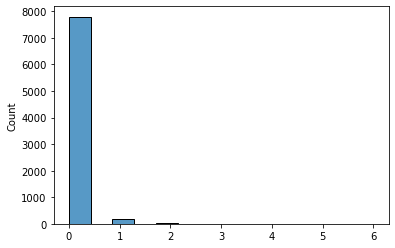

In [207]:
# mediante el diccionario obtendremos el código del token para realizar el histograma.

sns.histplot(X_train[:,vocabulary_dictionary2['uninstal']])

<AxesSubplot:ylabel='Count'>

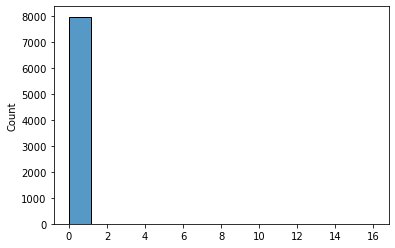

In [206]:
sns.histplot(X_train[:,vocabulary_dictionary2['love']])

<AxesSubplot:ylabel='Count'>

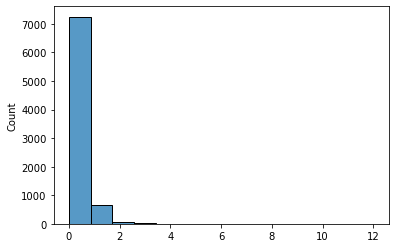

In [205]:
sns.histplot(X_train[:,vocabulary_dictionary2['great']])

<AxesSubplot:ylabel='Count'>

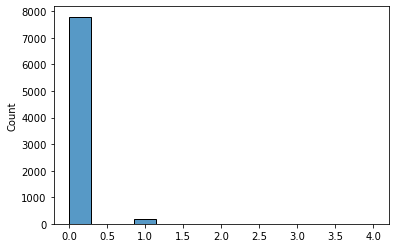

In [204]:
sns.histplot(X_train[:,vocabulary_dictionary2['wast']])

<AxesSubplot:ylabel='Count'>

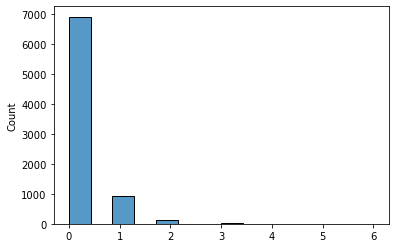

In [203]:
sns.histplot(X_train[:,vocabulary_dictionary2['delet']])

<AxesSubplot:ylabel='Count'>

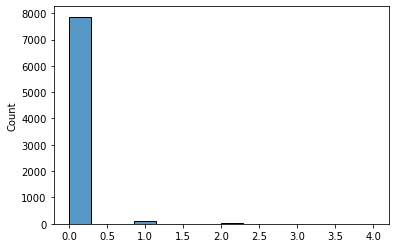

In [202]:
sns.histplot(X_train[:,vocabulary_dictionary2['bore']])

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

¿Que distribución presentan los datos?, ¿a qué crees que es debido?
</div>

La distribución es muy desigual. Apenas hay reseñas en las que aparezcan estos adjetivos.

Esto puede deberse a que las personas pueden usar diferentes adjetivos para mostrar que están satisfechas. Por ejemplo, habrá gente que usará la palabra great/good/brillant/love/satisfied... para referirse a lo mismo, que están contentos con el producto.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Repite los histogramas separando por colores la variable objetivo (dentro del mismo gráfico, diferenciar entre si la reseña es buena o no).
    
<u>Nota</u>: puedes utilizar el parámetro `alpha` para que se vean los dos gráficos a la vez.
</div>

In [197]:
y_train.shape

(8000,)

In [201]:
X_train[:,vocabulary_dictionary2['uninstal']].shape

(8000,)

In [219]:
X_train[:,vocabulary_dictionary2['uninstal']]

array([0., 0., 0., ..., 0., 0., 0.])

In [222]:
y_train

array([1, 1, 0, ..., 0, 1, 1])

In [198]:
vocabulary_dictionary2['uninstal']

372

(array([7.794e+03, 1.830e+02, 0.000e+00, 2.000e+01, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

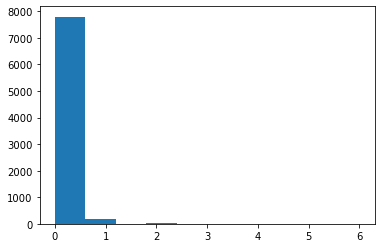

In [373]:
plt.hist(X_train[:,vocabulary_dictionary2['uninstal']])

In [383]:
np.transpose(y_train)

array([1, 1, 0, ..., 0, 1, 1])

In [386]:
train_df = pd.DataFrame(X_train, columns=list(vocabulary_dictionary2.keys()))
train_df['y'] = y_train
train_df.head()

,easier,handi,quit,version,site,color,chang,annoy,old,space,...,well,fi,year,yet,today,start,seem,hour,alreadi,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

¿Qué conclusiones puedes sacar de estas últimas gráficas?
</div>

Las gráficas muestran como para las variables que expresan características positivas, son más frecuentes en las reseñas que resultan ser positivas. Y sucede lo contrario con las reseñas que no son positivas, que están más presentes en la categoría de no positivas.

## 2.3. Entrenamiento del modelo

En este subapartado construiremos varios modelos con las ténicas vistas previamente y estudiaremos su comportamiento.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un árbol de decisión de profundidad 3 con las muestras del conjunto de entrenamiento.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [227]:
#construyo un árbol con profundidad 3

dtc = DecisionTreeClassifier(max_depth=3, min_samples_split=2)

scores = cross_val_score(dtc, X_train, y_train, cv=5)
scores

array([0.74625 , 0.73625 , 0.74125 , 0.740625, 0.7425  ])

In [228]:
print("Precisión:", scores)

print("%0.2f accuracy con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

Precisión: [0.74625  0.73625  0.74125  0.740625 0.7425  ]
0.74 accuracy con una desviación estándar de 0.00


In [230]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(dtc, X_train, y_train, cv=3)

accuracy_score(y_train, y_train_pred)

0.7425

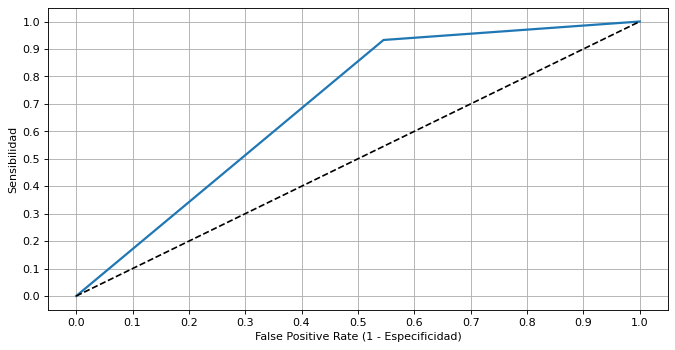

In [261]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_scores = cross_val_predict(dtc, X_train,y_train, cv=5)

fpr, tpr, thresh = roc_curve(y_train, y_train_pred)

def plot_roc(fpr, tpr):
    plt.figure(figsize=(10, 5), dpi=80)
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1], 'k--')
    plt.grid(True)
    plt.xticks(np.linspace(0, 1, 11))
    plt.yticks(np.linspace(0, 1, 11))
    plt.ylabel('Sensibilidad')
    plt.xlabel('False Positive Rate (1 - Especificidad)')


plot_roc(fpr, tpr)
plt.show()

In [262]:
roc_auc_score(y_train, y_train_pred)

0.6936790364622045

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Comprueba qué atributos son los más importantes del árbol mostrando sus nodos y los pares variable-valor que utiliza cada uno de ellos para dividir y subdividir los datos. Es importante que en los nodos del árbol aparezca a qué token hace referencia.

<u>Nota:</u> el siguiente enlace muestra una forma elegante de visualizar los nodos de los árboles: https://mljar.com/blog/visualize-decision-tree/.
</div>

In [246]:
X_train_df = pd.DataFrame(X_train, columns=list(vocabulary_dictionary2.keys()))
X_train_df.head()

,easier,handi,quit,version,site,color,chang,annoy,old,space,...,inform,well,fi,year,yet,today,start,seem,hour,alreadi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [247]:
dtc.fit(X_train_df, y_train)

text_representation = tree.export_text(dtc)
print(text_representation)

|--- feature_371 <= 0.50
|   |--- feature_232 <= 0.50
|   |   |--- feature_330 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_330 >  0.50
|   |   |   |--- class: 1
|   |--- feature_232 >  0.50
|   |   |--- feature_122 <= 1.50
|   |   |   |--- class: 1
|   |   |--- feature_122 >  1.50
|   |   |   |--- class: 0
|--- feature_371 >  0.50
|   |--- feature_306 <= 0.50
|   |   |--- feature_100 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_100 >  0.50
|   |   |   |--- class: 1
|   |--- feature_306 >  0.50
|   |   |--- feature_386 <= 1.00
|   |   |   |--- class: 1
|   |   |--- feature_386 >  1.00
|   |   |   |--- class: 0



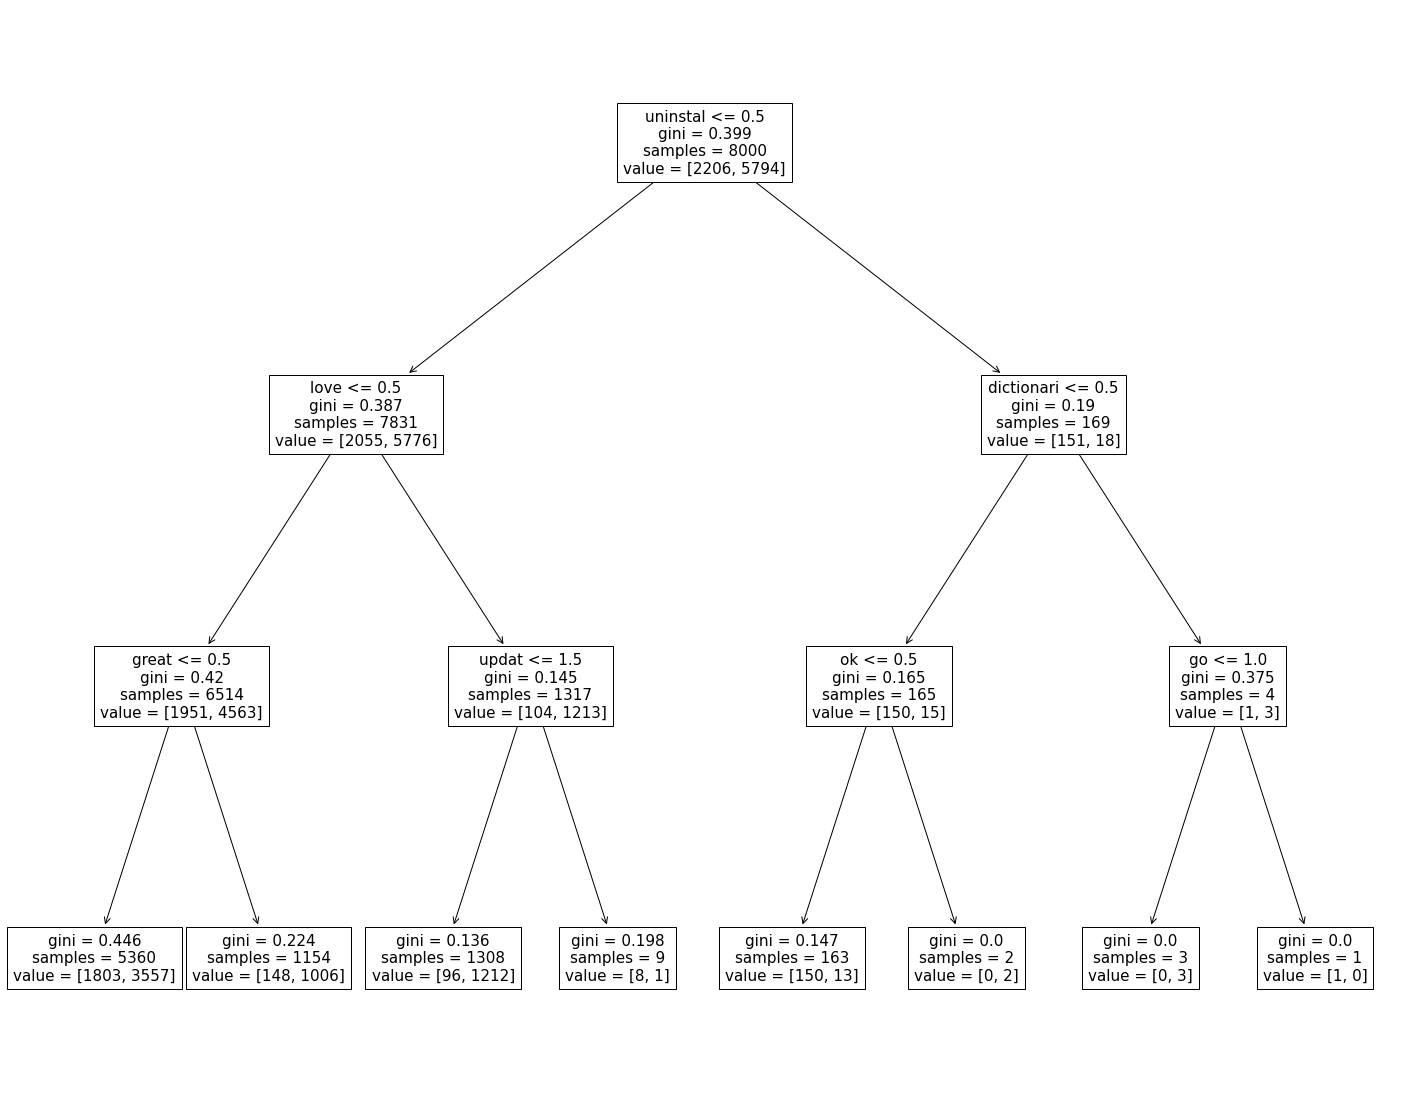

In [250]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, 
                   feature_names=list(vocabulary_dictionary2.keys()))


<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Según el árbol de decisión, ¿qué tokens son los más importantes a la hora de discriminar si un comentario es bueno o no?
</div>

Según esto, los tokens más importantes son aquellos que tienen un gini mayor. En este caso, estos serían uninstall, love y great. Todos con un valor de Gini superior a 0.38.

Otra buena forma de analizar qué atributos descriptivos son los más interesantes para discriminar a qué clase pertenece cada muestra es construir un _random forest_ para estudiar la _feature importance_ de los atributos descriptivos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Calcula el valor óptimo de los hiperparámetros `max_depth` y `n_estimators` para un `RandomForestClassifier`. Utiliza una búsqueda de rejilla con la métrica `roc_auc` y con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcula su promedio y la desviación estándar de dicha métrica.
    
Puedes utilizar el módulo `GridSearchCV` de `sklearn` para obtener la mejor combinación de hiperparámetros.
</div>

In [267]:
param_grid = {'n_estimators':[5, 10, 50],
              'max_depth':[2, 5, 10, 25]}

rfc = RandomForestClassifier(random_state=42)

In [268]:
grid_rfc = GridSearchCV(rfc, param_grid, cv=3)
grid_rfc.fit(X_train, y_train)
grid_rfc.best_params_

{'max_depth': 25, 'n_estimators': 50}

In [269]:
grid_rfc.cv_results_

{'mean_fit_time': array([0.03664351, 0.04703291, 0.17269063, 0.03713592, 0.06550566,
        0.26504342, 0.05240901, 0.08903289, 0.40802018, 0.08665562,
        0.16172393, 0.70624479]),
 'std_fit_time': array([0.00728614, 0.00023783, 0.00021802, 0.00692528, 0.00980587,
        0.01034639, 0.00712513, 0.00736997, 0.01295326, 0.00629504,
        0.00352336, 0.01285248]),
 'mean_score_time': array([0.        , 0.00955264, 0.0052096 , 0.00267959, 0.00520627,
        0.02286688, 0.00520611, 0.00521119, 0.01574723, 0.00972605,
        0.0087196 , 0.03141403]),
 'std_score_time': array([0.        , 0.00683598, 0.00736749, 0.00378951, 0.00736277,
        0.00641652, 0.00736255, 0.00736974, 0.00018837, 0.00493979,
        0.00650535, 0.00023917]),
 'param_max_depth': masked_array(data=[2, 2, 2, 5, 5, 5, 10, 10, 10, 25, 25, 25],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=

In [271]:
rfc = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=25)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.7835


En este caso, el número de estimators era el nivel máximo, para hilar más fino, puedo probar valores más elevedos para optimizar aún más el modelo.

In [272]:
param_grid = {'n_estimators':[50, 100, 200],
              'max_depth':[25, 50, 100]}

rfc = RandomForestClassifier(random_state=42)

grid_rfc = GridSearchCV(rfc, param_grid, cv=3)
grid_rfc.fit(X_train, y_train)
grid_rfc.best_params_

{'max_depth': 100, 'n_estimators': 100}

Este proceso lo puedo repetir hasta lograr unos parámetros con los que estoy satisfecho.

In [274]:
param_grid = {'n_estimators':[80, 100, 110, 130],
              'max_depth':[80, 100, 120]}

rfc = RandomForestClassifier(random_state=42)

grid_rfc = GridSearchCV(rfc, param_grid, cv=3)
grid_rfc.fit(X_train, y_train)
grid_rfc.best_params_

{'max_depth': 100, 'n_estimators': 100}

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con la mejor configuración de hiperparámetros encontrada, construye un modelo de clasificación con _random forest_.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [273]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=100)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.798


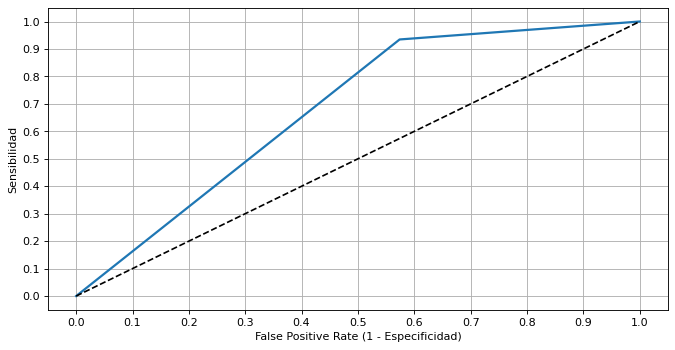

In [277]:
y_scores = cross_val_predict(rfc, X_train,y_train, cv=5)

fpr, tpr, thresh = roc_curve(y_train, y_scores)
plot_roc(fpr, tpr)
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el modelo de _random forest_ construido, muestra cuáles son los tokens más importantes para discriminar a qué clase pertenece cada muestra según el modelo.

<u>Nota:</u> utiliza el atributo `feature_importances_` del modelo de _random forest_ creado.
</div>

In [305]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=100)
rfc.fit(X_train_df, y_train)

RandomForestClassifier(max_depth=100, random_state=42)

In [284]:
# para mostrar los tokens más importantes, creo un dataframe
dat_dic = {'features': list(X_train_df.columns), 'importance': rfc.feature_importances_}
dat_df = pd.DataFrame(data=dat_dic)
dat_df.head()

,features,importance
0,easier,0.001149
1,handi,0.001339
2,quit,0.001108
3,version,0.003175
4,site,0.001559


In [295]:
# selecciono las features con mayor importancia
# las que tienen un valor más alto en importance

feat_imp = dat_df.sort_values(by=['importance'], ignore_index=True, ascending=False).iloc[:10]
feat_imp
# REFERENCES
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_

,features,importance
0,love,0.027177
1,uninstal,0.024506
2,great,0.023504
3,wast,0.015782
4,delet,0.015242
5,app,0.012526
6,game,0.011171
7,like,0.010070
8,bore,0.009633
9,easi,0.009452


<AxesSubplot:xlabel='features'>

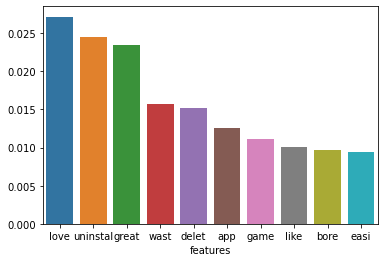

In [304]:
sns.barplot(x=feat_imp['features'], y=np.array(feat_imp['importance']))

En el gráfico se puede ver como los atributos más importantes son love, uninstal y great. Después se producen un salto en importancia con el resto. 

Si quisieramos reducir la dimensionalidad, podríamos seleccionar algunos de estos atributos con más importancia. También se podrían usar otros métodos como los métodos de reducción de la dimensionalidad. Aún así, en algunas circunstancias importa la interpretabilidad del modelo y seleccionar los atributos más importantes puede ser mejor que obtener unos componentes principales que es más difícil entender qué significan.

Tradicionalmente, modelos probabilísticos como el de Naïve-Bayes han demostrado ser bastante efectivos con problemas similares.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un modelo con `GaussianNB`.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [309]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.7395


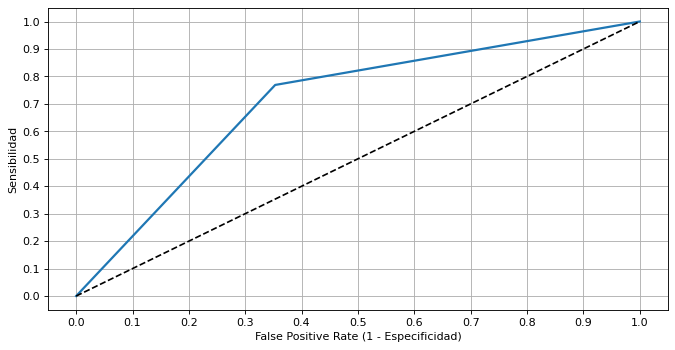

In [310]:
y_scores = cross_val_predict(clf, X_train,y_train, cv=5)

fpr, tpr, thresh = roc_curve(y_train, y_scores)
plot_roc(fpr, tpr)
plt.show()

Finalmente, comprobaremos qué tal se comporta un clasificador lineal en nuestro problema.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un modelo con `SVC` con `kernel` lineal.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [255]:
param_grid = {'C':[0.01, 0.1, 1, 10, 50, 100, 200],
              'gamma':[0.001, 0.01, 0.1, 1, 10],
              'kernel':['linear']}

svm = SVC()
grid = GridSearchCV(svm, param_grid, cv=3)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}


KeyError: 'c'

In [256]:
clf = SVC(C=grid.best_params_['C'], gamma = grid.best_params_['gamma'],
          kernel='linear', random_state=42)

scores = cross_val_score(clf, X_train,y_train, cv=5)

print("%0.2f accuracy con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

y_train_pred = cross_val_predict(clf, X_train,y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

0.80 accuracy con una desviación estándar de 0.01


array([[1003, 1203],
       [ 390, 5404]], dtype=int64)

Como hice con el modelo anterior, puedo probar valores intermedios para mejorar todavía más el modelo:

In [307]:
param_grid = {'C':[0.05, 0.1, 0.5],
              'gamma':[0.0001, 0.001, 0.05],
              'kernel':['linear']}

svm = SVC()
grid = GridSearchCV(svm, param_grid, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.05, 0.1, 0.5], 'gamma': [0.0001, 0.001, 0.05],
                         'kernel': ['linear']})

In [311]:
print(grid.best_params_)

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


In [312]:
param_grid = {'C':[0.1],
              'gamma':[0.00005, 0.0001, 0.0005],
              'kernel':['linear']}

svm = SVC()
grid = GridSearchCV(svm, param_grid, cv=3)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'C': 0.1, 'gamma': 5e-05, 'kernel': 'linear'}


In [313]:
clf = SVC(C=0.1, gamma = 0.00005,
          kernel='linear', random_state=42)

scores = cross_val_score(clf, X_train,y_train, cv=5)

print("%0.2f accuracy con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

y_train_pred = cross_val_predict(clf, X_train,y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

0.80 accuracy con una desviación estándar de 0.01


array([[1003, 1203],
       [ 390, 5404]], dtype=int64)

In [314]:
y_scores = cross_val_predict(clf, X_train,y_train, cv=5,
                            method = 'decision_function')

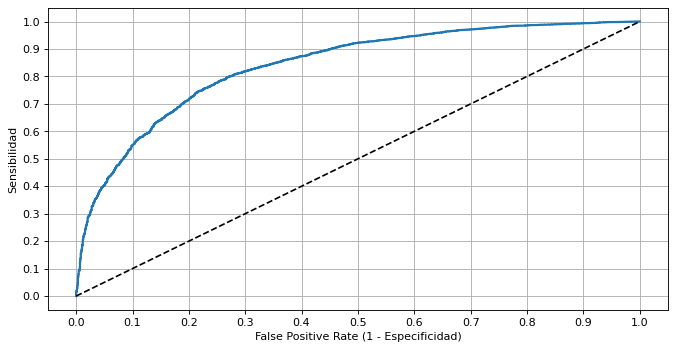

In [315]:
fpr, tpr, thresh = roc_curve(y_train, y_scores)

plot_roc(fpr, tpr)
plt.show()

SVM permite usar el método de decision function y permite establecer el modelo para maximizar la sensibilidad o la especificidad. En función del problema en el que nos encontremos, querremos establecer un valor específico de sensibilidad. Por ejemplo, en el caso del diagnóstico de una enfermedad, querremos que la sensibilidad del modelo sea muy alta y así detectar el máximo número de pacientes con la enfermedad aunque aumenten el número de falsos positivos.

Otra manera de mejorar la accuracy del modelo es utilizar los modelos que mejor han funcionado de forma conjunta. En lo que se conoce como ensambling, un método es a través de votaciones. Cada modelo vota por una opción y la opción más votada es la que se selecciona. Hay métodos más complejos en los que los modelos con mayor capacidad de predicción tienen más peso en la decisión final (Géron, 2019).

In [316]:
# el código está adaptado de "Hands on Machine Learning"

from sklearn.ensemble import VotingClassifier

svm = SVC(C=0.1, gamma = 0.00005,
          kernel='linear', random_state=42)

gnb = GaussianNB()

rfc = RandomForestClassifier(random_state=42,
                             n_estimators=100, max_depth=100)

voting = VotingClassifier(estimators=[('rf', rfc), ('svc', svm), ('gnb', gnb)],
                         voting='hard')

voting.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=100,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, gamma=5e-05, kernel='linear',
                                  random_state=42)),
                             ('gnb', GaussianNB())])

In [319]:
scores = cross_val_score(voting, X_train, y_train, cv=5)

print("%0.2f accuracy con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

0.80 accuracy con una desviación estándar de 0.01


### Modelo Final

In [321]:
# entrenamos los datos con todos los datos de test, sin cv
# y generamos el modelo final.

final_model = SVC(kernel='linear', C=0.1, gamma =0.00005,
                  random_state=42)

final_model.fit(X_train, y_train)

final_predictions = final_model.predict(X_test)

In [322]:
confusion_matrix(y_test, final_predictions)

array([[ 258,  294],
       [  99, 1349]], dtype=int64)

In [323]:
accuracy_score(y_test, final_predictions)

0.8035

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Comenta los resultados obtenidos.
</div>

El mejor modelo obtenido es el de SVM que obtiene una precisión del 80% con una desviación estandar del 1%. Este modelo es ligeramente superior al mejor modelo de random forest, que tenía un 78% de precisión.

Además, con SVM podría cambiar el rango de sensibilidad y especificidad en caso de desaerlo si las necesidades del proyecto lo requirieran. 

Pese a esto, cabe poner el foco en que no estamos clasificando correctamente el 20% de las instancias con este modelo y que sería recomendable mejorar los datos o los modelos. En este sentido, he buscado usar un método de ensamblaje mediante la votación dura, pero el modelo resultante no ha mejorado los resultados anteriores. 

Otros modelos como el XGBoost son muy utilizados en competiciones y son famosos por superar las predicciones de otros modelos (Géron, 2019). Alternativamente, los datos de entrenamiento podrían no ser los más indicados y se podría buscar alguna base de datos alternativa para entrenar los modelos. También se podrían emplear métodos alternativos de natural language processing para generar estos modelos.

## 2.4. Predicción de nuevos casos

En este caso vamos a comprobar cómo se comporta el mejor de nuestros clasificadores con dos reseñas completamente nuevas.

In [324]:
new_reviews = [
    {
        'reviewText': "The best application ever!!!",
        'overall': 5.0,
    },
    {
        'reviewText': "The worst application ever :'(",
        'overall': 1.0,
    },
]

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el mejor de los modelos creados, predice si estas dos nuevas reseñas son buenas o no.
</div>

In [325]:
new_reviews[0]['reviewText']

'The best application ever!!!'

In [328]:
y1 = process_review(new_reviews[0])[0]
y1

['best', 'applic', 'ever']

In [371]:
mtx = np.zeros([1, 399])

for i in range(0, len(y1)):
    print(c[y1[i]])
    mtx[0][c[y1[i]]] += 1
    

135
381
344


In [366]:
final_model.predict(mtx)

array([1])

In [370]:
y2 = process_review(new_reviews[1])[0]

mtx = np.zeros([1, 399])

for i in range(0, len(y2)):
    print(c[y2[i]])
    mtx[0][c[y2[i]]] += 1

y2

0
381
344


['worst', 'applic', 'ever']

In [368]:
final_model.predict(mtx)

array([1])

El modelo entrenado no está funcionando tan bien como sería esperable, ya que tanto a la reseña buena como a la mala las está clasificando como buenas. Esto puede ser porque el modelo esté asignando la mayoría de las instancias como buenas independientemente de los datos de predicción. Esto sucede a veces cuando hay datos con un desvalance en una de las categorías. El modelo tiene un buen rendimiento únicamente porque asigna todas las instancias a la clase dominante. Pese a ello, el modelo no ha sido capaz de clasificar correctamente la instancia negativa.

## 2.5. BONUS

Comprueba si las deducciones obtenidas para las reseñas de aplicaciones de Android tienen sentido en otro tipo de productos.

Descárgate las reseñas de otro tipo de producto y compruébalo.